In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Function to inject uniform noise into a tensor
def inject_noise(x, noise_ratio, activation_range):
    noise_scale = noise_ratio * (activation_range[1] - activation_range[0])
    noise = torch.empty_like(x).uniform_(-noise_scale, noise_scale)
    return x + noise

# Define the CNN model with Noise Injection
class CIFAR10_NoiseCNN(nn.Module):
    def __init__(self, noise_ratio=0.1):
        """
        Initializes the CNN model with noise injection.

        Parameters:
        - noise_ratio (float): Maximum noise ratio to be injected into activations.
        """
        super(CIFAR10_NoiseCNN, self).__init__()
        self.noise_ratio = noise_ratio

        # Define the network layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 256)  # Corrected input features
        self.fc2 = nn.Linear(256, 10)

    def forward_once(self, x):
        """
        Performs a single forward pass with noise injection.

        Parameters:
        - x (Tensor): Input tensor.

        Returns:
        - Tensor: Output logits.
        """
        # First convolutional layer + ReLU + noise
        x = F.relu(self.conv1(x))
        x = inject_noise(x, self.noise_ratio, activation_range=(0, 1))

        # Second convolutional layer + ReLU + noise
        x = F.relu(self.conv2(x))
        x = inject_noise(x, self.noise_ratio, activation_range=(0, 1))

        # Pooling
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 64 * 16 * 16)  # Corrected flattening

        # Fully connected layer + Tanh + noise
        x = torch.tanh(self.fc1(x))
        x = inject_noise(x, self.noise_ratio, activation_range=(-1, 1))

        # Output layer
        x = self.fc2(x)
        return x

    def forward(self, x, num_inferences=1):
        """
        Performs multiple forward passes with noise injection and averages the outputs.

        Parameters:
        - x (Tensor): Input tensor.
        - num_inferences (int): Number of noisy forward passes.

        Returns:
        - Tensor: Averaged output logits.
        """
        if num_inferences > 1:
            # Perform multiple forward passes with noise, collect outputs
            outputs = []
            for _ in range(num_inferences):
                out = self.forward_once(x)  # Shape: (batch_size, num_classes)
                outputs.append(out.unsqueeze(0))  # Shape: (1, batch_size, num_classes)
            # Stack and average
            outputs = torch.cat(outputs, dim=0)  # Shape: (num_inferences, batch_size, num_classes)
            avg_output = torch.mean(outputs, dim=0)  # Shape: (batch_size, num_classes)
            return avg_output
        else:
            # Single forward pass
            return self.forward_once(x)

# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training and testing datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define DataLoaders with consistent batch sizes
batch_size = 128  # Consistent batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Experiment Parameters
noise_ratios = [0.000001,0.01, 0.1]
num_inferences_list = [1, 2, 5, 10, 20,50]

# Number of epochs
num_epochs = 5

# To store results
results = []

# Start the experiments
experiment_number = 1
total_experiments = len(noise_ratios) * len(num_inferences_list)
for noise_ratio in noise_ratios:
    for num_inferences in num_inferences_list:
        print(f"\nExperiment {experiment_number}/{total_experiments}: Noise Ratio = {noise_ratio}, Num Inferences = {num_inferences}")
        experiment_number += 1

        # Initialize a new model for each experiment
        model = CIFAR10_NoiseCNN(noise_ratio=noise_ratio).to(device)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Store training losses
        training_losses = []

        # Training loop
        for epoch in range(1, num_epochs + 1):
            model.train()
            running_loss = 0.0
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()

                # Perform multiple forward passes with noise, average outputs
                outputs = []
                for _ in range(num_inferences):
                    out = model.forward_once(data)
                    outputs.append(out.unsqueeze(0))
                outputs = torch.cat(outputs, dim=0)
                avg_output = torch.mean(outputs, dim=0)

                # Compute loss
                loss = criterion(avg_output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_epoch_loss = running_loss / len(train_loader)
            training_losses.append(avg_epoch_loss)
            print(f"Epoch {epoch}/{num_epochs}, Training Loss: {avg_epoch_loss:.4f}")

        # Testing loop
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                # Perform multiple forward passes with noise, average outputs
                outputs = []
                for _ in range(num_inferences):
                    out = model.forward_once(data)
                    outputs.append(out.unsqueeze(0))
                outputs = torch.cat(outputs, dim=0)
                avg_output = torch.mean(outputs, dim=0)

                # Compute loss
                loss = criterion(avg_output, target)
                test_loss += loss.item() * data.size(0)

                # Compute accuracy
                _, predicted = torch.max(avg_output, 1)
                correct += (predicted == target).sum().item()
                total += target.size(0)

        avg_test_loss = test_loss / total
        accuracy = 100. * correct / total
        print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

        # Store results
        results.append({
            'noise_ratio': noise_ratio,
            'num_inferences': num_inferences,
            'training_loss': training_losses[-1],  # Loss after the last epoch
            'test_accuracy': accuracy
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)


Files already downloaded and verified
Files already downloaded and verified
Using device: cuda

Experiment 1/18: Noise Ratio = 1e-06, Num Inferences = 1
Epoch 1/5, Training Loss: 1.3699
Epoch 2/5, Training Loss: 0.9295
Epoch 3/5, Training Loss: 0.7303
Epoch 4/5, Training Loss: 0.5473
Epoch 5/5, Training Loss: 0.3457
Test Loss: 0.9466, Test Accuracy: 69.95%

Experiment 2/18: Noise Ratio = 1e-06, Num Inferences = 2
Epoch 1/5, Training Loss: 1.2727
Epoch 2/5, Training Loss: 0.8699
Epoch 3/5, Training Loss: 0.6697
Epoch 4/5, Training Loss: 0.4759
Epoch 5/5, Training Loss: 0.2789
Test Loss: 0.9529, Test Accuracy: 70.36%

Experiment 3/18: Noise Ratio = 1e-06, Num Inferences = 5
Epoch 1/5, Training Loss: 1.2916
Epoch 2/5, Training Loss: 0.8910
Epoch 3/5, Training Loss: 0.7019
Epoch 4/5, Training Loss: 0.5097
Epoch 5/5, Training Loss: 0.3175
Test Loss: 0.9241, Test Accuracy: 70.98%

Experiment 4/18: Noise Ratio = 1e-06, Num Inferences = 10
Epoch 1/5, Training Loss: 1.3072
Epoch 2/5, Training L

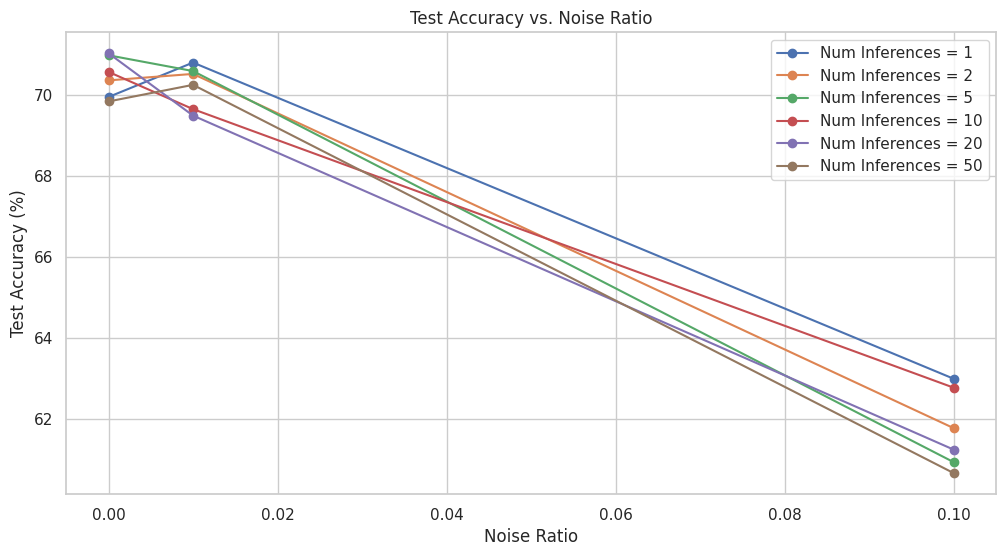

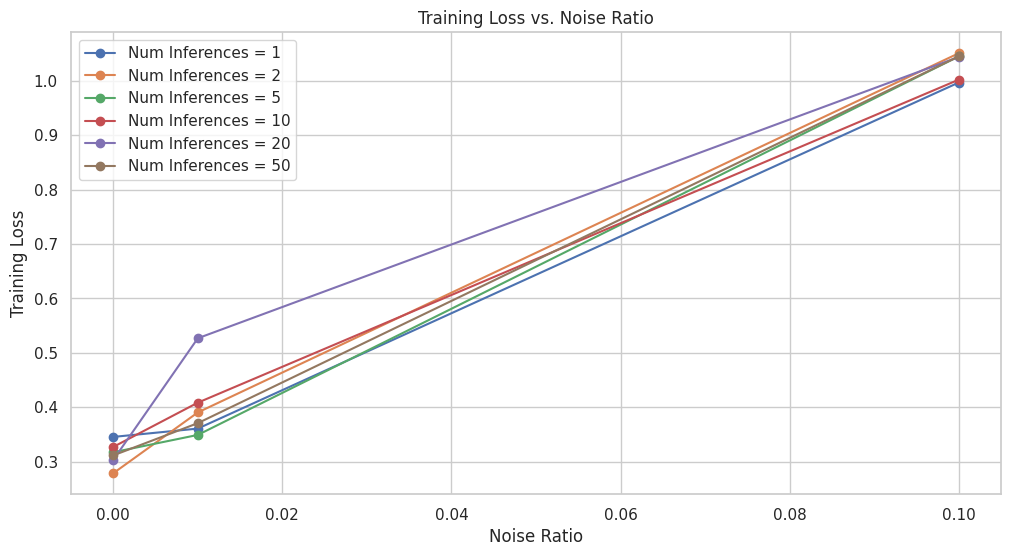

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot Test Accuracy vs. Noise Ratio for different Number of Inferences
plt.figure(figsize=(12, 6))
for num_inferences in num_inferences_list:
    subset = results_df[results_df['num_inferences'] == num_inferences]
    plt.plot(subset['noise_ratio'], subset['test_accuracy'], marker='o', label=f'Num Inferences = {num_inferences}')
plt.title('Test Accuracy vs. Noise Ratio')
plt.xlabel('Noise Ratio')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.show()

# Plot Training Loss vs. Noise Ratio for different Number of Inferences
plt.figure(figsize=(12, 6))
for num_inferences in num_inferences_list:
    subset = results_df[results_df['num_inferences'] == num_inferences]
    plt.plot(subset['noise_ratio'], subset['training_loss'], marker='o', label=f'Num Inferences = {num_inferences}')
plt.title('Training Loss vs. Noise Ratio')
plt.xlabel('Noise Ratio')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Heatmap of Test Accuracy
accuracy_pivot = results_df.pivot("num_inferences", "noise_ratio", "test_accuracy")
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Test Accuracy Heatmap')
plt.xlabel('Noise Ratio')
plt.ylabel('Number of Inferences')
plt.show()

# Heatmap of Training Loss
loss_pivot = results_df.pivot("num_inferences", "noise_ratio", "training_loss")
plt.figure(figsize=(10, 8))
sns.heatmap(loss_pivot, annot=True, fmt=".4f", cmap="YlOrRd")
plt.title('Training Loss Heatmap')
plt.xlabel('Noise Ratio')
plt.ylabel('Number of Inferences')
plt.show()
